In [2]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [3]:
def get_top_stats(graph, i, cut=10, axis=0):
    return np.array(sorted(graph[i])[::-1][:cut]), np.argsort(graph[i])[::-1][:cut]

In [4]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [5]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy", embs)

In [6]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [7]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [8]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [9]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [11]:
paths = [
    '/home/rykachevskiy/CRISPR_research/data/patients/27',
]



In [55]:
res_all = [process_path(x) for x in paths]

/home/rykachevskiy/CRISPR_research/data/patients/27/out/pairs/27_S1_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 477/477 [00:00<00:00, 2229.50it/s]


calc embs


In [56]:
reads = [x[0] for x in res_all]
grs = [x[1] for x in res_all]
embs = [x[2] for x in res_all]

In [57]:
gr = grs[0]

In [403]:
gr.shape

(346, 346)

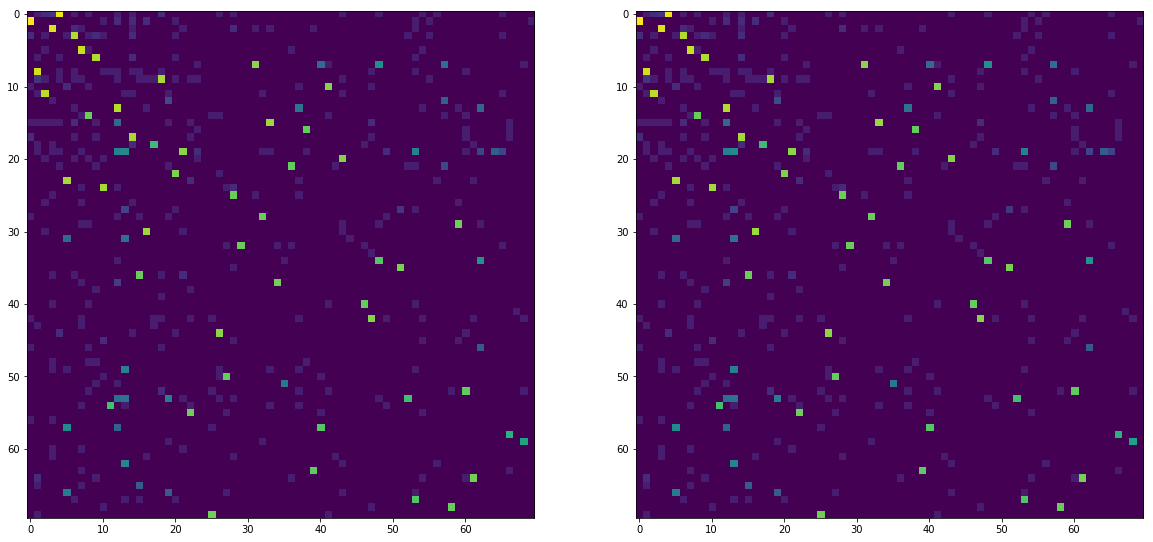

In [407]:
cut = 70
ca.plot_grs(#grs_m[0][:cut, :cut],
            grs[0][:cut, :cut],
            grs[0][:cut, :cut],
            #preds[:cut, :cut],
            #grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [340]:
gr_copy = np.copy(gr)

In [341]:
gr_copy[gr < 25] = 0 

In [24]:
get_top_stats(gr.T, 53)

(array([665,  48,  31,   1,   1,   1,   1,   1,   1,   1]),
 array([ 67,  19, 218,  49, 136,  66,  21, 224, 138,  40]))

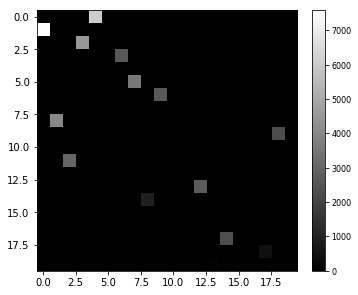

In [63]:
ca.plot_gr(gr_copy[:20,:20], s = 8)
plt.show()

In [366]:
def get_routes(graph, route, routes, vertex, verbose=0):
    candidates = np.where(graph[vertex] > 0)[0]
    #print(candidates)
    if len(candidates) == 0:
        #print("a", routes)
        if verbose: 
            print(vertex, 'no edges')
        routes.append(route)
    else:
        is_final = 1
        for candidate in candidates:
            
#             if (len(route) < 2 and (not candidate in route)) or ((not candidate in route) and \
#               (np.abs(gr[route[-1], candidate] - np.median(ca.get_weights(graph, [route])[0]) \
#                       / np.median(ca.get_weights(graph, [route])[0] < 0.5)))):
            if not candidate in route:

                if len(route) > 1:
                    #m = np.median(ca.get_weights(graph, [route])[0])
                    weights = ca.get_weights(graph, [route])[0]
                    min_idx = np.argmin([abs(x -  gr[route[-1], candidate]) for x in weights])
                    m = abs(weights[min_idx] - gr[route[-1], candidate])
                    if verbose: 
                        print(route,
                              candidate,
                              ca.get_weights(graph, [route])[0],
                              gr[route[-1],candidate],
                              m,
                              m / min(weights[min_idx], gr[route[-1], candidate]) )                 
                if (len(route) <= 1) or m / min(weights[min_idx], gr[route[-1], candidate]) < 1.5:
                    is_final = 0
                    new_route = [x for x in route]
                    new_route.append(candidate)
                    #print('n', new_route)
                    get_routes(graph, new_route, routes,candidate, verbose)
        if is_final:
            #print("a", routes)
            routes.append(route)

In [367]:
def restore_arrays_all(graph):
    start_vertexes = np.arange(gr.shape[0])#np.where(graph.sum(0) == 0)[0]

    answ = []

    for vertex in start_vertexes:
        routes = []
        route = [vertex]
        get_routes(graph, route, routes, vertex)

        answ.extend(routes)

    return answ

In [368]:
get_top_stats(gr_copy.T, 1)

(array([4045,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([  8, 345, 118, 110, 111, 112, 113, 114, 115, 116]))

In [369]:
routes[:2]

[[146, 63]]

In [370]:
routes = []
get_routes(gr_copy, [169], routes, 169, verbose=True)
routes

[169, 110] 144 [220] 219 1 0.00456621004566
[169, 110, 144] 197 [220, 219] 114 105 0.921052631579
197 no edges
[169, 110] 162 [220] 105 115 1.09523809524
[169, 110, 162] 118 [220, 105] 131 26 0.247619047619
[169, 110, 162, 118] 105 [220, 105, 131] 379 159 0.722727272727
[169, 110, 162, 118, 105] 62 [220, 105, 131, 379] 219 1 0.00456621004566
[169, 110, 162, 118, 105, 62] 13 [220, 105, 131, 379, 219] 57 48 0.842105263158
[169, 110, 162, 118, 105, 62, 13] 12 [220, 105, 131, 379, 219, 57] 2722 2343 6.18205804749
[169, 110, 162, 118, 105, 62, 13] 37 [220, 105, 131, 379, 219, 57] 29 28 0.965517241379
[169, 110, 162, 118, 105, 62, 13, 37] 34 [220, 105, 131, 379, 219, 57, 29] 1184 805 2.12401055409
[169, 110, 162, 118, 105, 62, 13, 37] 95 [220, 105, 131, 379, 219, 57, 29] 59 2 0.0350877192982
[169, 110, 162, 118, 105, 62, 13, 37, 95] 40 [220, 105, 131, 379, 219, 57, 29, 59] 26 3 0.115384615385
[169, 110, 162, 118, 105, 62, 13, 37, 95, 40] 46 [220, 105, 131, 379, 219, 57, 29, 59, 26] 923 544 1

[[169, 110, 144, 197],
 [169, 110, 162, 118, 105, 62, 13, 37, 95, 40, 46, 111, 164, 121, 94],
 [169, 110, 162, 118, 105, 62, 13, 37, 95, 100, 184, 216],
 [169, 110, 162, 118, 105, 62, 13, 37, 95, 109, 178],
 [169, 110, 162, 118, 105, 62, 13, 203, 205, 152, 159, 88],
 [169,
  110,
  162,
  118,
  105,
  62,
  13,
  203,
  205,
  152,
  228,
  172,
  161,
  189,
  201,
  253],
 [169, 110, 162, 118, 105, 62, 73, 84, 90, 106, 130, 214]]

In [371]:
gr_copy = np.copy(gr)

In [372]:
gr_copy[gr < 25] = 0 

In [373]:
all_2 = sorted(restore_arrays_all(gr_copy), key = len)[::-1]
len([x for x in all_2 if len(x) > 2])

245

In [2]:
def merge(a):
    a_s = sorted(a, key = len)[::-1]
    f_a =[]
    for array in a_s:
        if not ca.a_in_any_b(array, f_a):
            f_a.append(array)
    return f_a

In [374]:
f_all_2 =[]
for a in all_2:
    if not ca.a_in_any_b(a, f_all_2):
        f_all_2.append(a)

In [375]:
for i in range(300):
    if not i in ca.unwrap_nested(f_all_2):
        print(i)

In [382]:
f_all_2

[[169,
  110,
  162,
  118,
  105,
  62,
  13,
  203,
  205,
  152,
  228,
  172,
  161,
  189,
  201,
  253],
 [164, 121, 94, 37, 34, 62, 13, 203, 205, 152, 228, 172, 161, 189, 201, 253],
 [169, 110, 162, 118, 105, 62, 13, 37, 95, 40, 46, 111, 164, 121, 94],
 [66, 133, 37, 95, 13, 203, 205, 152, 228, 172, 161, 189, 201, 253],
 [250, 182, 19, 13, 203, 205, 152, 228, 172, 161, 189, 201, 253],
 [218, 53, 19, 13, 203, 205, 152, 228, 172, 161, 189, 201, 253],
 [51, 160, 157, 209, 241, 176, 152, 228, 172, 161, 189, 201, 253],
 [169, 110, 162, 118, 105, 62, 73, 84, 90, 106, 130, 214],
 [169, 110, 162, 118, 105, 62, 13, 203, 205, 152, 159, 88],
 [169, 110, 162, 118, 105, 62, 13, 37, 95, 100, 184, 216],
 [164, 121, 94, 37, 34, 62, 73, 84, 90, 106, 130, 214],
 [164, 121, 94, 37, 34, 62, 13, 203, 205, 152, 159, 88],
 [80, 19, 13, 203, 205, 152, 228, 172, 161, 189, 201, 253],
 [169, 110, 162, 118, 105, 62, 13, 37, 95, 109, 178],
 [164, 121, 94, 37, 34, 62, 13, 12, 100, 184, 216],
 [250, 182, 19, 

In [376]:
pred_gr = ca.graph_from_arrays(f_all_2)[0]

In [377]:
get_top_stats(gr.T, 63)

(array([345,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([146, 345, 117, 110, 111, 112, 113, 114, 115, 116]))

In [383]:
routes = []
get_routes(gr_copy, [11], routes, 11, 1)

[11, 2] 3 [3023] 4513 1490 0.492887859742
[11, 2, 3] 6 [3023, 4513] 2619 404 0.154257350134
[11, 2, 3, 6] 9 [3023, 4513, 2619] 2624 5 0.00190912562047
[11, 2, 3, 6, 9] 18 [3023, 4513, 2619, 2624] 2280 339 0.148684210526
[11, 2, 3, 6, 9, 18] 17 [3023, 4513, 2619, 2624, 2280] 457 1823 3.98905908096


In [380]:
ca.get_weights(gr_copy, [[17, 14, 8, 1, 0, 4]])

[[2313, 992, 4045, 7580, 6080]]

In [386]:
get_top_stats(gr, 41)

(array([279,   1,   1,   0,   0,   0,   0,   0,   0,   0]),
 array([ 71,  88,  67, 108, 110, 111, 112, 113, 114, 115]))

In [388]:
ca.get_weights(gr, sorted([x for x in f_all_2 if len(x) > 2],
       key = lambda x: np.mean(ca.get_weights(gr, [x])[0]))[::-1][16:20])

[[190, 253, 563, 1184, 102, 57, 2722, 33, 193],
 [190, 253, 563, 1184, 102, 57, 2722, 43, 87, 64],
 [885, 397, 291, 721, 270],
 [291, 304, 675, 454, 486, 665, 510, 867, 321]]

In [389]:
arrs_sorted = sorted([x for x in f_all_2 if len(x) > 2],
       key = lambda x: np.mean(ca.get_weights(gr, [x])[0]))[::-1]

In [400]:
arrs_sorted[:10]

[[17, 14, 8, 1, 0, 4],
 [11, 2, 3, 6, 9, 18],
 [23, 5, 7, 31],
 [24, 10, 41],
 [30, 16, 38, 83],
 [82, 19, 21, 36, 15, 33],
 [55, 22, 20, 43],
 [69, 25, 28, 32, 29, 59],
 [71, 45, 88],
 [146, 63, 39, 77]]

In [390]:
r = reads[0]

In [401]:
ca.write_list_of_lists("./arrays_num_27p_cut25_range15.txt",[[str(x) for x in y] for y in arrs_sorted])

In [399]:
ca.write_list_of_lists("./weights_27p_cut25_range15.txt", [[str(x) for x in y] for y in ca.get_weights(gr, arrs_sorted)])

In [402]:
ca.dict_to_csv(r.index_to_cluster, './idx_to_sp')

In [296]:
min(ca.unwrap_nested(ca.get_weights(gr_copy, all_2)))

50

In [297]:
weights = ca.get_weights(gr_copy, all_2)

In [298]:
all_2[:10]

[[85, 65, 80, 67, 53, 52, 60, 145],
 [65, 80, 67, 53, 52, 60, 145],
 [82, 19, 21, 36, 15, 33],
 [80, 67, 53, 52, 60, 145],
 [69, 25, 28, 32, 29, 59],
 [11, 2, 3, 6, 9, 18],
 [137, 57, 40, 46, 111],
 [73, 84, 90, 106, 130],
 [67, 53, 52, 60, 145],
 [56, 97, 79, 76, 149]]

In [299]:
gr[np.array([13,19,53])][:, np.array([13,19,53])]

array([[ 0,  0,  0],
       [65,  0, 48],
       [29, 47,  0]])

In [290]:
weights[:3]

[[102, 57, 39, 51, 56, 56, 38, 161, 86, 64, 48],
 [51, 26, 48, 29, 39, 51, 56, 56, 38],
 [51, 26, 48, 29, 29, 59, 30, 87, 64]]

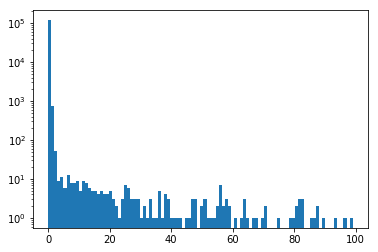

In [267]:
plt.hist(gr[gr < 100].flatten(), bins = 100, log = 2)
plt.show()

In [264]:
np.exp(3)

20.085536923187668

In [249]:
gr[19, 173]

25

In [250]:
gr[19, 53]

48

In [251]:
gr[173, 13]

16

In [252]:
gr[53, 13]

29

In [245]:
ca.get_weights(gr_copy, all_2[:1])

[[51, 26, 25, 16, 29, 59, 30, 87, 64, 20, 131]]

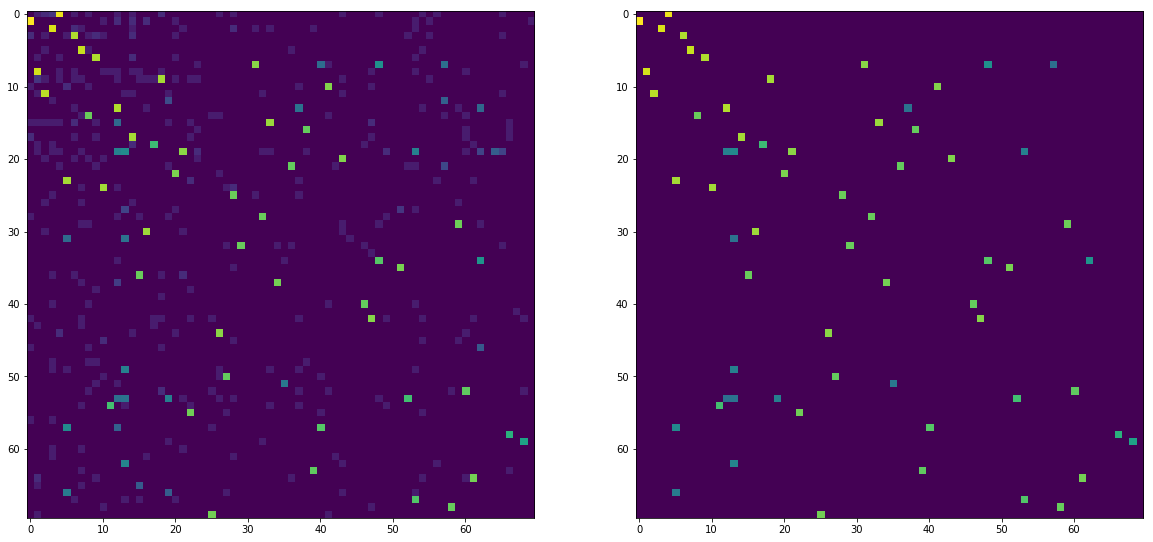

In [409]:
cut = 70
ca.plot_grs(#grs_m[0][:cut, :cut],
            grs[0][:cut, :cut],
            #grs[0][:cut, :cut],
            gr_copy[:cut, :cut],
            #grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [1]:
gr_copy

NameError: name 'gr_copy' is not defined

In [130]:
a_15_all = [x  for x in ca.restore_arrays_all((gr_copy > 0).astype(int)) if len(x) > 3]

In [134]:
len(a_15_all)

17596

In [131]:
w_15_all = ca.get_weights(gr, a_15_all)

In [132]:
def std_func(arr):
    return np.std(np.array(arr) / max(arr))

In [133]:
stds = [std_func(x) for x in w_15_all]

In [ ]:
plt.hist(stds, bins = 100)
plt.show()

In [127]:
get_top_stats(gr, 104)

(array([304,   1,   1,   0,   0,   0,   0,   0,   0,   0]),
 array([ 85, 133,  15, 117, 110, 111, 112, 113, 114, 115]))

In [104]:
embs_sq = embs[0].reshape(345, 345, 6)

In [103]:
embs_sq[7, 40]

array([ 0.99127907,  0.99127907,  0.01371497,  0.02761104,  3.17805383,
        3.17805383])

In [105]:
embs_sq[7, 48]

array([ 0.99709302,  0.99709302,  0.05247466,  0.10891089,  4.48863637,
        4.48863637])

In [106]:
embs_sq[7, 31]

array([ 1.        ,  1.        ,  0.91592129,  0.94348894,  7.33758774,
        7.33758774])

In [92]:
get_top_stats(gr, 7)

(array([1536,   88,   25,   23,    1,    1,    1,    1,    1,    0]),
 array([ 31,  48,  57,  40,  85,  68,  41,  23, 119, 113]))

In [71]:
get_top_stats(gr, 48)

(array([600,  21,   1,   1,   1,   1,   1,   1,   1,   1]),
 array([ 74, 133, 329,   3,   8,   9, 202,  38, 140, 101]))

In [77]:
get_top_stats(gr, 133)

(array([242,  39,   1,   1,   1,   1,   1,   1,   0,   0]),
 array([ 42,  37,   1, 127,  91, 106,  60,  16, 345, 118]))

In [78]:
get_top_stats(gr, 37)

(array([1184,   59,   14,    4,    1,    1,    1,    1,    0,    0]),
 array([ 34,  95,  74,  12, 145, 155,   7, 119, 345, 112]))

In [79]:
get_top_stats(gr, 95)

(array([362, 130,  30,  26,   1,   1,   1,   0,   0,   0]),
 array([109,  13, 100,  40, 134,  60, 129,  94, 121, 114]))

In [80]:
get_top_stats(gr, 13)

(array([2722,   39,   29,   19,    6,    1,    1,    1,    1,    1]),
 array([ 12, 203,  37,  62, 105, 315,   6,  54,  16,  59]))

In [81]:
get_top_stats(gr, 203)

(array([51, 18,  1,  0,  0,  0,  0,  0,  0,  0]),
 array([205, 104, 184, 345, 117, 110, 111, 112, 113, 114]))

In [82]:
get_top_stats(gr, 104)

(array([304,   1,   1,   0,   0,   0,   0,   0,   0,   0]),
 array([ 85, 133,  15, 117, 110, 111, 112, 113, 114, 115]))

In [86]:
r=  reads[0]

In [91]:
ca.dict_to_csv(r.corrector.spacers_to_occurrences, "./27_spacer_to_occurrences")

In [73]:
gr.shape

(346, 346)

In [65]:
gr = grs[0]

In [30]:
gb = pickle.load(open('../article/gb_rep_to_rep', 'rb'))

In [31]:
preds = gb.predict(embs[0]).reshape(grs[0].shape[0] - 1, grs[0].shape[1] - 1)

In [35]:
(preds > 0).sum(1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1,

In [32]:
a = [x for x in ca.restore_arrays_all(preds) if len(x) > 2]

In [33]:
w = ca.get_weights(grs[0], a)

In [36]:
a ,w = ca.restore_arrays_greedy(grs[0], 2)

In [40]:
[x for x in a if len(x) > 2]

[[93, 54, 11, 2, 3, 6, 9, 18, 17, 14, 8, 1, 0, 4, 86, 96, 302],
 [23, 5, 7, 31, 134, 207, 269],
 [213,
  139,
  103,
  114,
  171,
  286,
  150,
  127,
  191,
  181,
  200,
  223,
  151,
  13,
  12,
  101],
 [24, 10, 41, 71, 45, 88],
 [30, 16, 38, 83, 167, 55, 22, 20, 43, 156, 219, 294],
 [192, 82, 19, 21, 36, 15, 33],
 [44, 26, 112],
 [133, 42, 47],
 [217, 122, 108, 89, 35, 51, 160, 157, 209, 241, 176, 152, 159],
 [137, 57, 40, 46, 111, 164, 121, 94, 37, 34, 48, 74, 125, 165, 283],
 [102, 49, 92, 64, 61, 113],
 [69, 25, 28, 32, 29, 59, 68, 58],
 [75, 72, 170, 136, 132, 154, 227],
 [146, 63, 39, 77],
 [196, 135, 70, 81],
 [153, 91, 50, 27, 87],
 [315, 158, 129, 78, 56, 97, 79, 76, 149],
 [115, 116, 148, 104, 85, 65, 80, 67, 53, 52, 60, 145, 278],
 [180, 107, 100, 184, 216, 162, 118, 105, 62, 73, 84, 90, 106, 130, 214],
 [169, 110, 144, 197, 249, 211, 187, 95, 109, 178],
 [221, 124, 140],
 [119, 66, 141],
 [236, 126, 117, 138, 143, 163],
 [226, 199, 225, 142, 123, 155, 174, 279],
 [128,

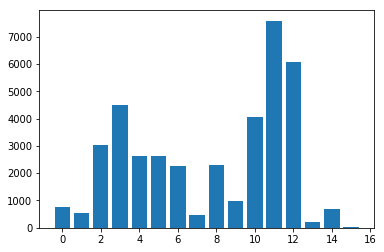

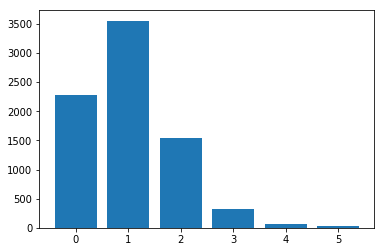

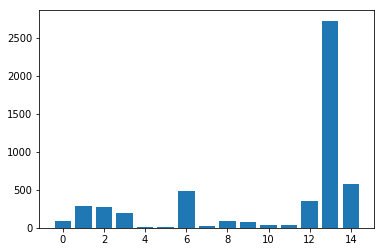

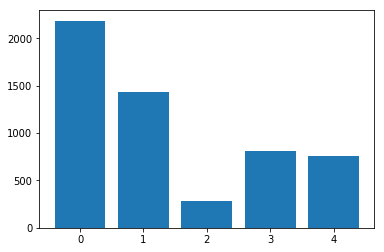

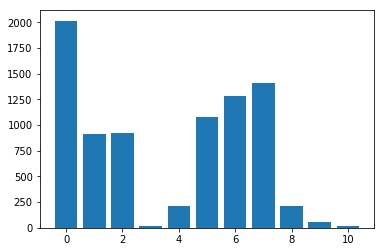

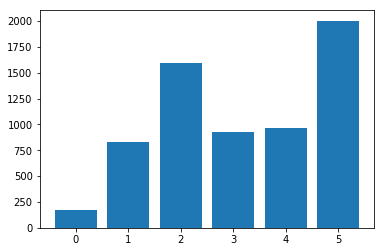

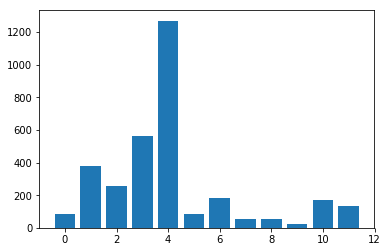

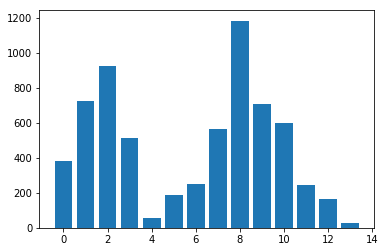

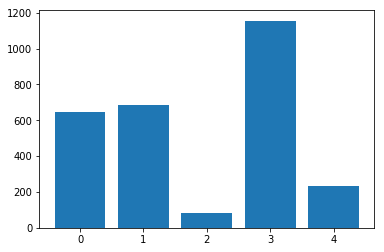

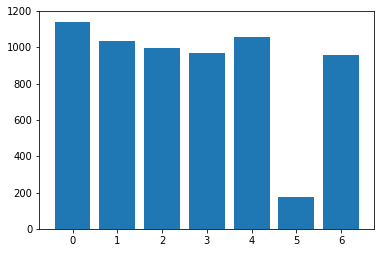

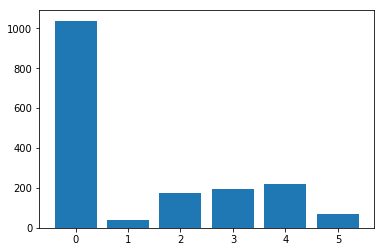

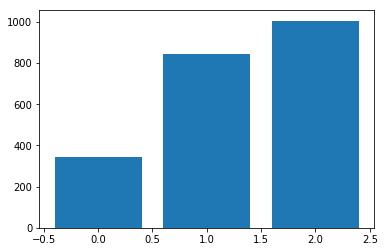

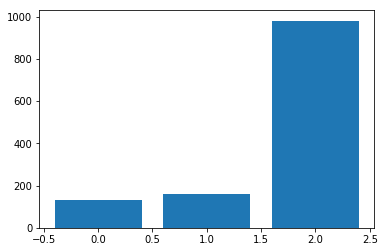

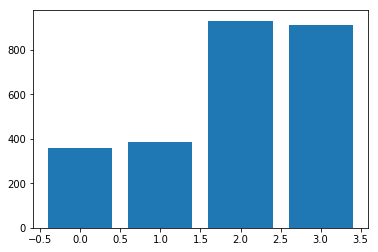

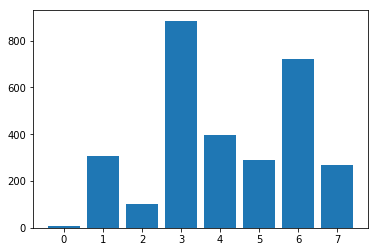

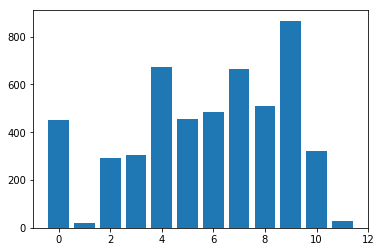

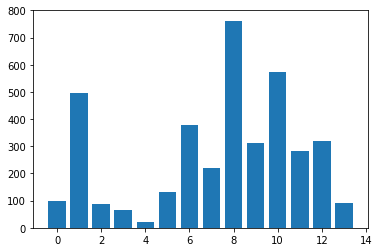

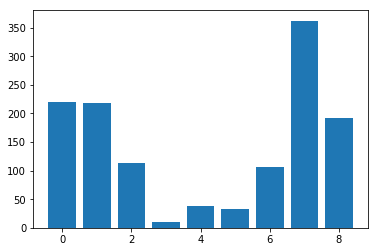

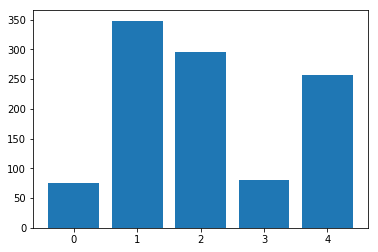

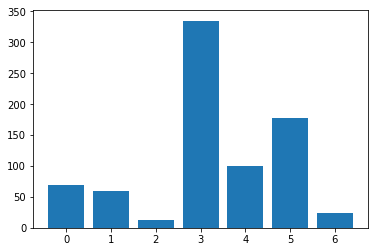

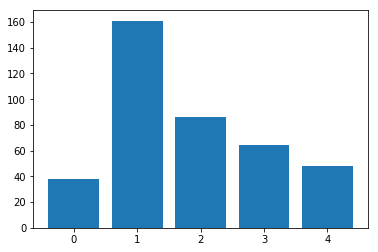

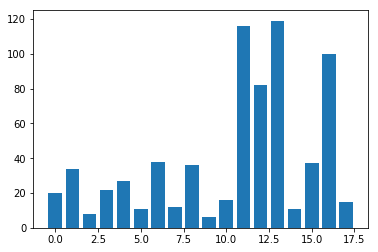

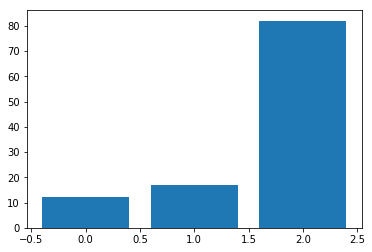

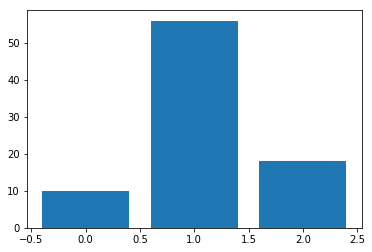

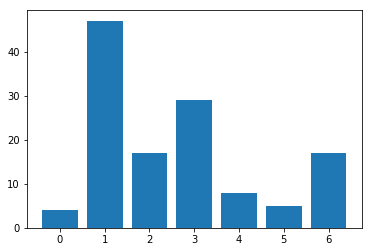

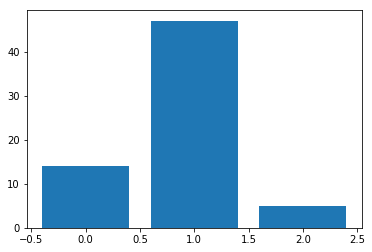

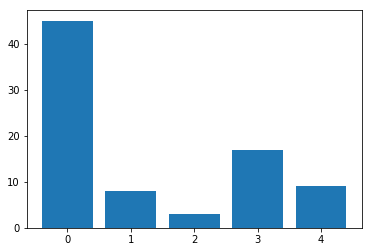

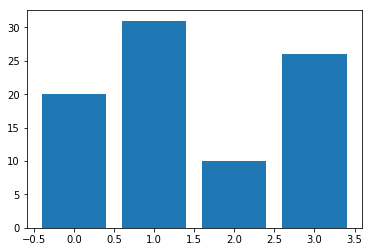

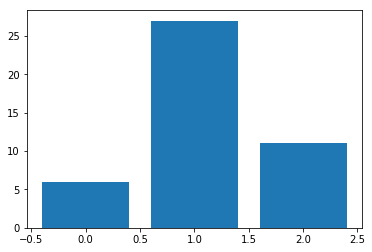

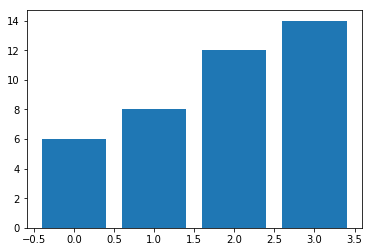

In [39]:
for we in [x for x in w if len(x) > 2]:
    plt.bar(np.arange(len(we)), we)
    plt.show()

In [162]:
gb.predict_proba([embs[0].reshape(274, 274, 6)[28,4]])

array([[ 0.95690392,  0.04309608]])

In [163]:
embs[0].reshape(274, 274, 6)[28,4]

array([  9.96336996e-01,   9.41391941e-01,   1.62393162e-01,
         1.54202005e-03,   4.74493213e+00,   4.74493213e+00])

In [152]:
gb.predict_proba([embs[0].reshape(274, 274, 6)[1,0]])

array([[  7.82389720e-09,   9.99999992e-01]])

In [145]:
embs[0].reshape(274, 274, 6)[1,0]

array([  1.        ,   1.        ,   0.93323107,   0.9282285 ,
        11.42143498,  11.42143498])

In [146]:
np.argsort(grs[0][0])[::-1]

array([  6,   8,  13,   9,   7,   4,   3,   5,   2,   1,  10,  15,  11,
        12,  17,  14,   0,  16,  25,  38,  26,  32,  36, 226,  31,  24,
        23,  27,  30,  21,  28,  55,  46,  35,  44,  37,  29,  19,  43,
        20,  34,  40,  18,  33, 109, 157,  22,  72,  56, 111, 108,  99,
        77,  67, 134,  42,  48,  39, 156, 100,  90, 101,  82,  81,  45,
        79,  41,  49, 179, 112,  71, 154, 210,  52, 130, 126, 178, 121,
       110, 103, 176, 174, 116, 135, 172, 117, 105, 140, 141, 158, 118,
       123, 147, 167,  53,  96, 192,  95,  68,  69, 209, 211,  76,  60,
        63,  59,  58,  84, 215,  91,  57, 127, 125, 128, 122, 129, 120,
       131,  51, 119,  61, 132,  64,  83,  54,  93,  47,  92,  88,  87,
       104, 107,  66,  80,  78,  75,  70, 113, 114, 115,  97, 137, 133,
       166, 169, 173, 175, 177, 181, 219, 186, 243, 190, 195, 236, 200,
       201, 230, 229, 136, 206, 207, 225, 223, 213, 257, 220, 165, 149,
       151, 138, 162, 142, 153, 148, 267, 235, 234, 233, 232, 23

In [139]:
grs[0].max(1)

array([82567, 91256, 70125, 79623, 66698, 41300, 13242, 65694, 62009,
       44389, 26353, 20546, 21747, 31351, 11839,   399,   336,  7765,
        2464,  2854,    10,   789,   369,   992,  1423,   438,   345,
         400,   409,   342,   436,   489,   354,   557,   221,   455,
         151,   252,   208,   458,   160,   444,   189,    84,    20,
         223,    16,   106,   230,   215,   176,   147,   150,   191,
         128,    16,   171,   144,   137,   150,   182,   154,   160,
         112,   116,    82,   141,   154,   131,   115,    99,   154,
         103,   103,    71,    81,   100,     2,    60,    61,     4,
          63,    54,    28,    32,    46,    41,    43,    74,    50,
          35,    52,    37,    23,    32,    35,    32,    58,    81,
          40,    28,    28,    78,    44,    28,    23,    17,    30,
          31,    44,    24,    49,    47,    37,    29,    33,    27,
          22,    21,    41,    24,    26,    25,    31,    57,    34,
          34,    31,

In [118]:
grs_m[1][0].astype(int)[:10]

array([   90,   407,   388,   364,   388,   465, 65322,   455,   734,   517])

In [124]:
grs_m[0][20].astype(int)

array([ 6,  3,  7,  6,  8, 10,  6,  3,  1,  2,  1,  1,  1,  2,  0,  2,  1,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [126]:
filtered_medians = [np.median(y) for y in ca.get_weights(grs[0],[x for x in ca.restore_arrays_greedy(grs[0])[0] if len(x) > 2]) if np.median(y) > 5]

In [128]:
ca.restore_arrays_greedy(grs[0])[0]

[[43,
  33,
  26,
  32,
  30,
  27,
  29,
  37,
  35,
  42,
  41,
  36,
  55,
  17,
  14,
  15,
  13,
  9,
  10,
  7,
  4,
  3,
  2,
  5,
  11,
  12,
  8,
  1,
  0,
  6,
  16,
  242,
  250],
 [227, 19, 18, 20],
 [112, 38, 24, 22, 34, 45, 28, 40, 31, 23, 21, 25, 44],
 [159, 52, 57, 39, 46, 267],
 [71, 47, 72, 70, 74, 76, 69, 60, 48, 51, 77],
 [64, 66, 59, 56, 58, 63, 62, 49, 54, 61, 53, 50, 65, 73, 68, 80],
 [98, 78, 81, 67],
 [236, 88, 75, 83, 99, 151, 258, 102, 79, 139],
 [165, 97, 85, 150],
 [205,
  204,
  214,
  155,
  130,
  129,
  152,
  198,
  186,
  136,
  118,
  146,
  91,
  86,
  82,
  94,
  148,
  235,
  229,
  181,
  170,
  200,
  216,
  109,
  110,
  174,
  211,
  192,
  103,
  84,
  163,
  184,
  154,
  203,
  162,
  107,
  128,
  201],
 [167,
  134,
  189,
  137,
  89,
  106,
  171,
  178,
  149,
  121,
  133,
  117,
  92,
  104,
  135,
  180,
  122,
  115,
  101,
  144,
  141,
  108,
  164],
 [175, 100, 143, 111, 105, 126, 87, 93, 114, 96, 127, 138, 188],
 [156,
  160,
 

In [107]:
for i in range(100):
    print(i, '-------------------')
    print(get_top_stats(grs[0], i, cut = 4)[0])
    print(get_top_stats(grs[0], i, cut = 4)[1])
    print(get_top_stats(preds, i, cut = 4)[1])
    print(get_top_stats(preds, i, cut = 4)[0])

0 -------------------
[6080    3    2    2]
[ 4  3  2 97]
[  4 344 117 109]
[1 0 0 0]
1 -------------------
[7580    2    2    2]
[ 0 12 14 16]
[  0 117 109 110]
[1 0 0 0]
2 -------------------
[4513    2    2    1]
[ 3 28  6 14]
[  3 344 117 109]
[1 0 0 0]
3 -------------------
[2619    2    2    2]
[ 6  0 14  9]
[  6 344 117 109]
[1 0 0 0]
4 -------------------
[208   1   0   0]
[ 86  73 108 110]
[ 86 117 109 110]
[1 0 0 0]
5 -------------------
[3553    1    1    1]
[  7  90 129  36]
[  7 344 117 109]
[1 0 0 0]
6 -------------------
[2624    2    1    1]
[  9  14 307 214]
[  9 344 117 109]
[1 0 0 0]
7 -------------------
[1536   88   25   23]
[31 48 57 40]
[ 31 344 110 111]
[1 0 0 0]
8 -------------------
[4045    1    1    1]
[ 1 14 47 60]
[  1 344 117 109]
[1 0 0 0]
9 -------------------
[2280    3    1    1]
[18  1 84 15]
[ 18 344 107 109]
[1 0 0 0]
10 -------------------
[1437    2    1    1]
[41  5  0  8]
[ 41 118 110 111]
[1 0 0 0]
11 -------------------
[3023    1    1    1]


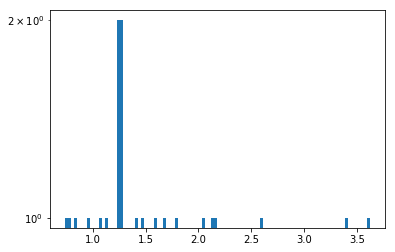

In [127]:
plt.hist([np.log10(filtered_medians)], bins = 100, log = 1)
plt.show()

### graphs

In [65]:
'/home/rykachevskiy/CRISPR_research/data/environmental/s3/out/pairs/SlO3_ATTCCT_L001_R1_001.fastq.gz_pairs.txt'

'/home/rykachevskiy/CRISPR_research/data/environmental/s3/out/pairs/SlO3_ATTCCT_L001_R1_001.fastq.gz_pairs.txt'

In [66]:
# reads =  [ca.Read(paths[0] + "pairs/SlO2_ACTGAT_L001_R1_001.fastq.gz_pairs.txt"),
#           ca.Read(paths[1] + "pairs/SlO3_ATTCCT_L001_R1_001.fastq.gz_pairs.txt")]

read = ca.Read(path)

In [67]:
len(read.contigs)

740835

In [68]:
read.correct_errors(minimum_occurences=5)

100%|██████████| 1226/1226 [00:00<00:00, 4092.13it/s]


In [69]:
gr = read.graph_from_pairs()[0]

In [70]:
gr.shape

(221, 221)

In [131]:
ca.plot_grs(gr[:200, :200], log =1)
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'flatten'

In [10]:
grs = [x.graph_from_pairs()[0] for x in reads]

In [11]:
np.save(paths[0] + "graph", grs[0])
np.save(paths[1] + "graph", grs[1])

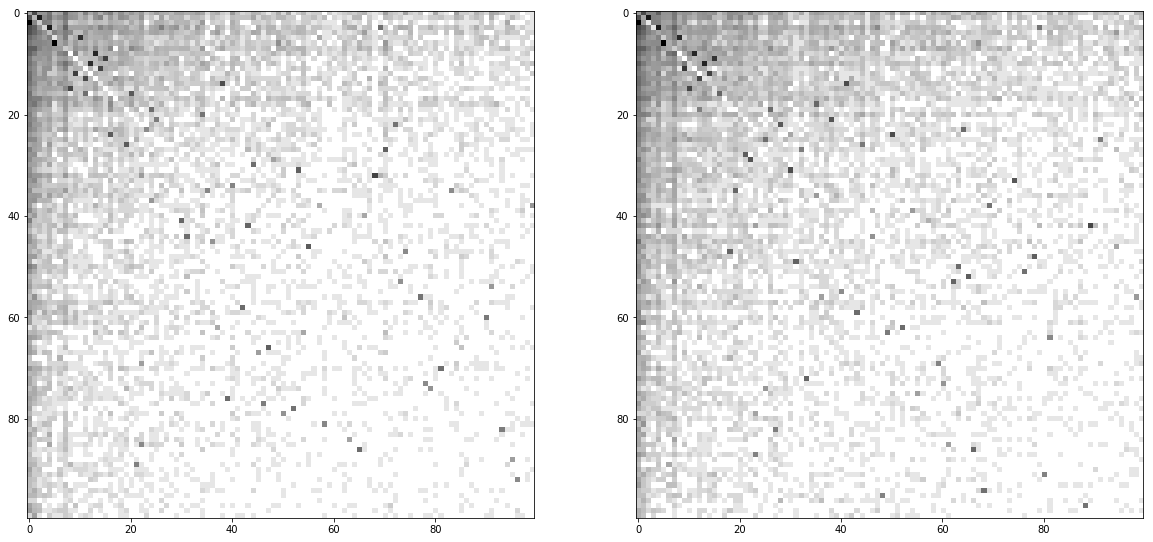

In [18]:
cut = 100
ca.plot_grs(grs[0][:100, :100], grs[1][:100, :100], log = 1, s=20)
plt.show()

In [17]:
[x.shape for x in grs]

[(2829, 2829), (3635, 3635)]

## Merge reads

In [34]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [35]:
d1 = {1 : 'AAA', 2 : 'CCC'}
d2 = {1 : 'AAB', 2: 'GGT', 3 : 'CCC'}

In [28]:
def merge_reads(reads):
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(reads, pointers):
        for i in range(len(reads)):
            if pointer[i] < len(reads[i].spacer_to_index):
                dist, closest = ca.find_closest(merged_sp_to_idxes, )
    

SyntaxError: invalid syntax (<ipython-input-28-22cf7978d4c7>, line 7)

In [20]:
r = reads[0]

In [25]:
r.corrector.spacers_to_occurrences

OrderedDict([('ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC', 3594),
             ('TGGCTCTGCAACAGCAGCACCCATGACCACGT', 2411),
             ('GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 2368),
             ('GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 1905),
             ('CTGTTTTCGCAAATCTATGGACTATTGCTATT', 1833),
             ('GTAGTCCATCATTCCACCTATGTCTGAACTCC', 1555),
             ('TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 1543),
             ('CAATCTGGGCGACCGGTCATCATCGCTTCGATG', 1210),
             ('GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 934),
             ('AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC', 884),
             ('CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 870),
             ('TCAACATTATCAATTACAACCGACAGGGAGCC', 833),
             ('TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 831),
             ('GCGACCGCTCAGAAATTCCAGACCCGATCCAAA', 823),
             ('AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 767),
             ('TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 666),
             ('CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG', 663),
             ('CAGAACATACTTCAAAGCCCGA

In [26]:
reads[1].corrector.spacers_to_occurrences

OrderedDict([('ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC', 4581),
             ('TGGCTCTGCAACAGCAGCACCCATGACCACGT', 2858),
             ('GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 2849),
             ('GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 2166),
             ('CTGTTTTCGCAAATCTATGGACTATTGCTATT', 2150),
             ('GTAGTCCATCATTCCACCTATGTCTGAACTCC', 2001),
             ('TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 1850),
             ('CAATCTGGGCGACCGGTCATCATCGCTTCGATG', 1488),
             ('CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 1254),
             ('AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC', 1213),
             ('GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 1205),
             ('TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 1119),
             ('TCAACATTATCAATTACAACCGACAGGGAGCC', 1072),
             ('GCGACCGCTCAGAAATTCCAGACCCGATCCAAA', 1062),
             ('AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 1042),
             ('TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 940),
             ('GCGGGCGTTAACGCGGTGATACTGTTTGACGG', 717),
             ('CAGAACATACTTCAA

In [27]:
r.spacer_to_cluster_index

{'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC': 0,
 'TGGCTCTGCAACAGCAGCACCCATGACCACGT': 1,
 'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC': 2,
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC': 3,
 'CTGTTTTCGCAAATCTATGGACTATTGCTATT': 4,
 'GTAGTCCATCATTCCACCTATGTCTGAACTCC': 5,
 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG': 6,
 'CAATCTGGGCGACCGGTCATCATCGCTTCGATG': 7,
 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG': 8,
 'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC': 9,
 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC': 10,
 'TCAACATTATCAATTACAACCGACAGGGAGCC': 11,
 'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG': 12,
 'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA': 13,
 'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG': 14,
 'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA': 15,
 'CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG': 16,
 'CAGAACATACTTCAAAGCCCGAGGCGTACACG': 17,
 'TAGGCCTATAGAGACGAGCGTTCGTTAAAGCA': 18,
 'ATAGACCCCGAACAACAATACGCGCAAACCGA': 19,
 'AACGTCAGGTTGTCGCCGCTCTGCGTGGTCGC': 20,
 'GATCAGATAAATGGCGAGACGATCCTGTTGCAC': 21,
 'AGTGCTGGACCATTTCAAATTCACAATAGATT': 22,
 'GCGGGCGTTAACGCGGTGATACTGTTTGACGG': 23,
 'TACCGTACAGACTGCCGGAT

### embs

In [40]:
ec =ca.EmbeddingsCalculator()
ec.make_argsorts(gr[:cut, :cut])
embs = ec.fit_predict(gr[:cut, :cut], njobs=32)

In [41]:
embs = ec.fit_predict(gr[:cut, :cut], njobs=32)

In [17]:
#embs = np.load("../../../Ecoli_env/m2/out/embs.npy")
np.save("/home/rykachevskiy/CRISPR_research/data/environmental/c2/out/embs", embs)


In [15]:
path

'/home/rykachevskiy/CRISPR_research/data/environmental/c2/out/pairs/cat2_L001_R1_001.fastq.gz_pairs.txt'

In [42]:
gb = pickle.load(open("./gb_rep_to_rep", 'rb'))

In [44]:
preds = gb.predict_proba(embs)[:,1].reshape(gr[:cut, :cut].shape)

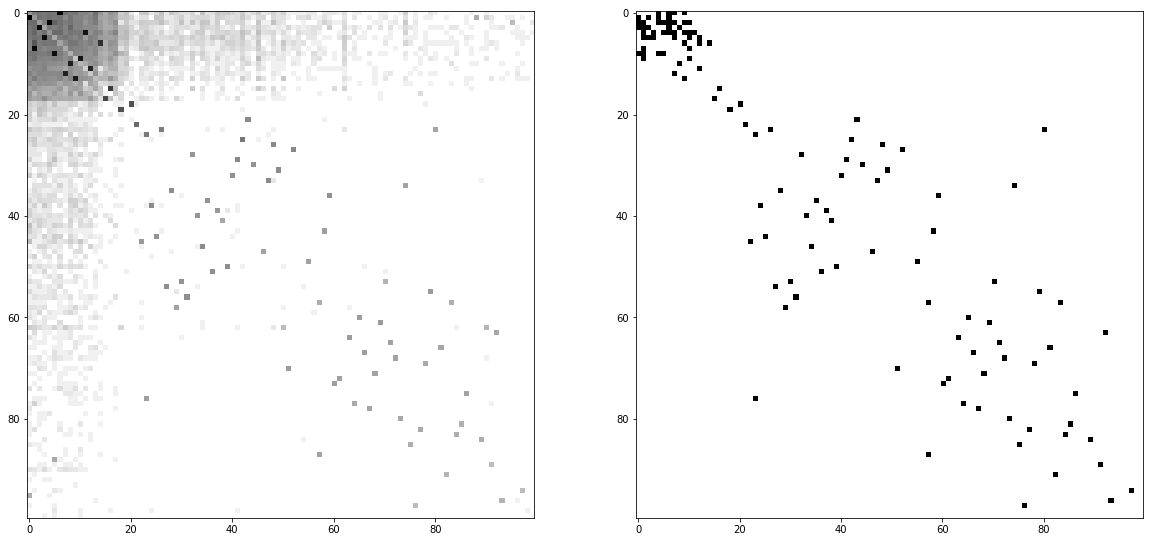

In [45]:
cut = 100
ca.plot_grs(gr[:cut,:cut], preds[:cut,:cut] > 0.5, log =1, s = 20)

In [62]:
np.where(gr.max(1) == 26)

(array([497]),)

In [64]:
gr[1]

array([94733,   101,   587,   458,   554,   482,   541,   211,   504,
         266,   258,   164,   243,   447,    62,    53,    84,    63,
          12,    13,     6,     1,     3,     3,     0,    12,    11,
           2,     2,     4,     8,     2,     4,     5,     5,     5,
           2,     8,     6,     4,     3,     4,    11,     4,     1,
           4,     5,     0,     5,     3,     3,     1,     0,     3,
           3,     5,     1,     1,     3,     1,     0,     0,     2,
           0,     2,     0,     0,     1,     0,     1,     2,     0,
           1,     0,     3,     0,     1,     0,     1,     1,     0,
           0,     1,     0,     0,     0,     1,     0,    39,     0,
           6,     2,     0,     0,     1,     1,     0,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     1,
           0,     0,     0,     0,     1,     0,     0,     0,     0,
           0,     0,     0,     2,     0,     0,     0,     0,     1,
           0,     0,

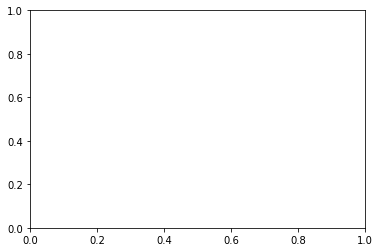

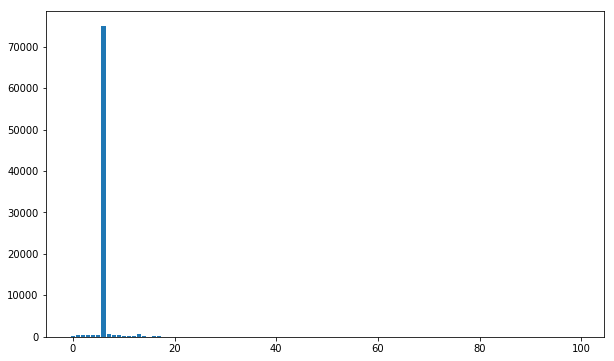

In [48]:
plt.figure(figsize = (10, 6))
plt.bar(np.arange(cut), gr[0][:cut] + 1)
plt.show()

In [24]:
gr[0]

array([   91,   409,   389,   367,   389,   468,   458, 65513,   738,
         519,   250,   234,   185,   652,    96,   248,    59,   168,
           4,     7,    16,     3,     7,    21,    10,    14,     6,
          23,    26,    15,    11,    11,    11,     8,    26,    10,
          11,    16,    19,    12,     7,    12,    10,     2,    10,
           1,     2,     4,     3,     3,    12,     2,     0,     1,
           3,     3,     1,     1,     0,     1,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     2,     0,     1,
           0,     0,     1,     0,     1,     2,     0,     3,     0,
           0,     1,     1,     2,     2,     2,     0,     1,     0,
           0,     0,     0,     1,     0,     0,     3,     2,     0,
           0,     0,     1,     1,     0,     2,     1,     0,     0,
           0,     1,     1,     0,     0,     1,     0,     0,     0,
           1,     0,     0,     0,     0,    17,     0,     1,     1,
           0,     0,

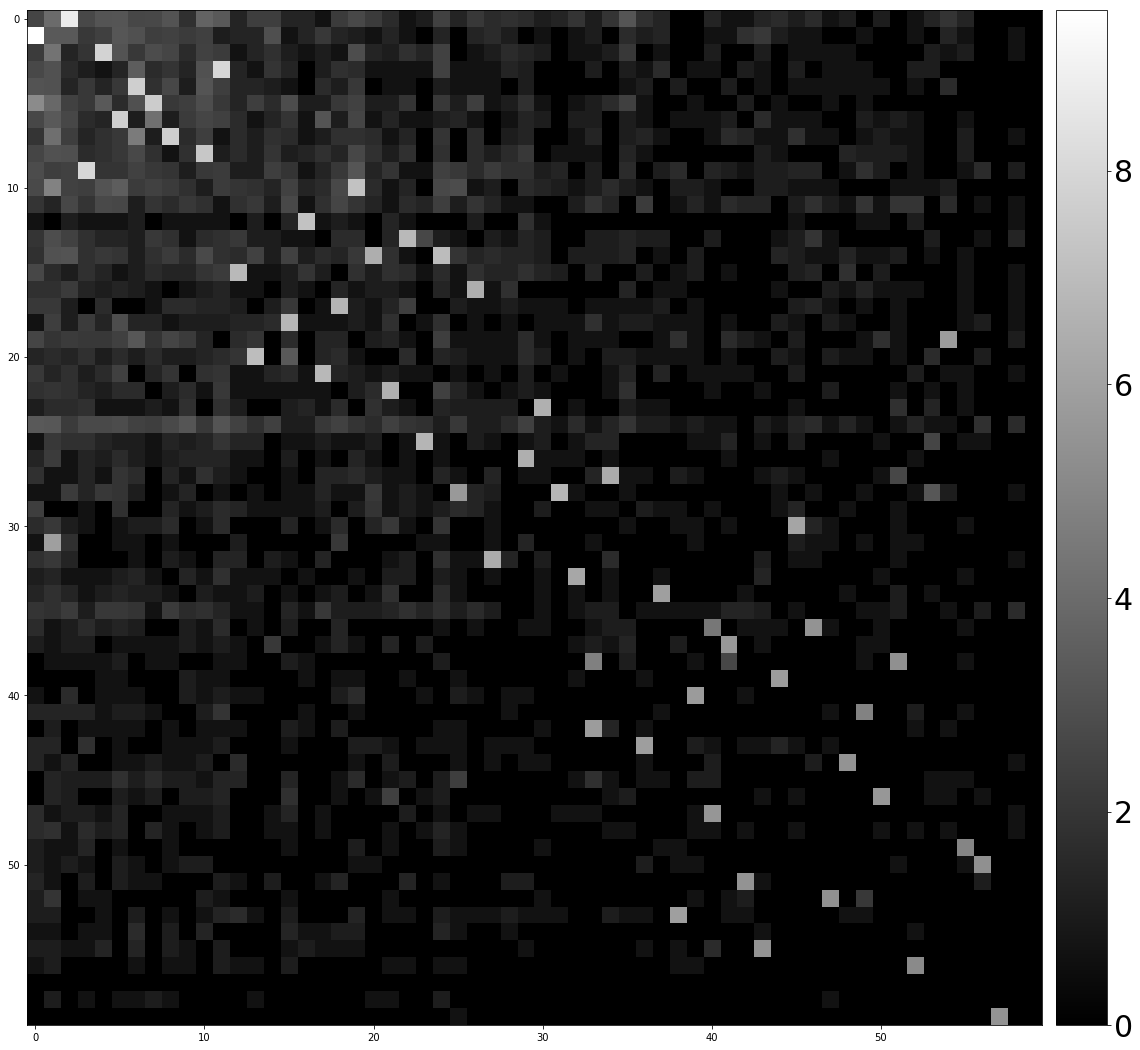

In [34]:
cut = 60
ca.plot_gr(gr[:cut,:cut], log = 1, s = 30, save_path="./slo", all_ticks=0)
plt.show()

In [35]:
get_top_stats(gr, 28)

(array([877, 292,  79,  25,  13,   8,   7,   7,   7,   6]),
 array([ 31,  25,  74,  53, 242,   2,   4,  20, 190,   5]))

In [37]:
get_top_stats(preds, 28)

(array([  9.99639410e-01,   2.77795110e-01,   6.13370253e-02,
          2.40353250e-03,   1.60886381e-03,   1.60886381e-03,
          2.82336667e-04,   1.58908208e-04,   1.58908208e-04,
          1.58908208e-04]),
 array([ 31,  25,  74, 242, 493, 190,  53,   6,  18,  49]))

In [38]:
preds[28, 53]

0.00028233666681546548

In [40]:
embs_sq = embs.reshape(gr.shape[0], gr.shape[1], 6)

In [41]:
embs_sq[28][31]

array([ 1.        ,  1.        ,  0.63781818,  0.95016251,  6.77764659,
        6.77764659])

In [42]:
embs_sq[28][25]

array([ 0.99960815,  1.        ,  0.21236364,  0.64317181,  5.68017261,
        5.68017261])

In [50]:
for v, i in zip(*get_top_stats(preds, 28)):
    print(v, embs_sq[28][i])

0.999639409933 [ 1.          1.          0.63781818  0.95016251  6.77764659  6.77764659]
0.277795109973 [ 0.99960815  1.          0.21236364  0.64317181  5.68017261  5.68017261]
0.0613370252526 [ 0.9992163   1.          0.05745455  0.76699029  4.38202663  4.38202663]
0.00240353249703 [ 0.9984326   1.          0.00945455  1.          2.63905733  2.63905733]
0.00160886381019 [ 0.9960815   1.          0.00363636  0.83333333  1.79175947  1.79175947]
0.00160886381019 [ 0.9968652   1.          0.00509091  0.77777778  2.07944154  2.07944154]
0.000282336666815 [ 0.99882445  1.          0.01818182  0.3968254   3.25809654  3.25809654]
0.000158908207799 [  9.92554859e-01   9.79623824e-01   1.45454545e-03   7.51314801e-04
   1.09861229e+00   1.09861229e+00]
0.000158908207799 [  9.86285266e-01   9.61990596e-01   7.27272727e-04   9.17431193e-04
   6.93147181e-01   6.93147181e-01]
0.000158908207799 [  9.90987461e-01   9.93730408e-01   7.27272727e-04   2.90697674e-03
   6.93147181e-01   6.93147181e-01

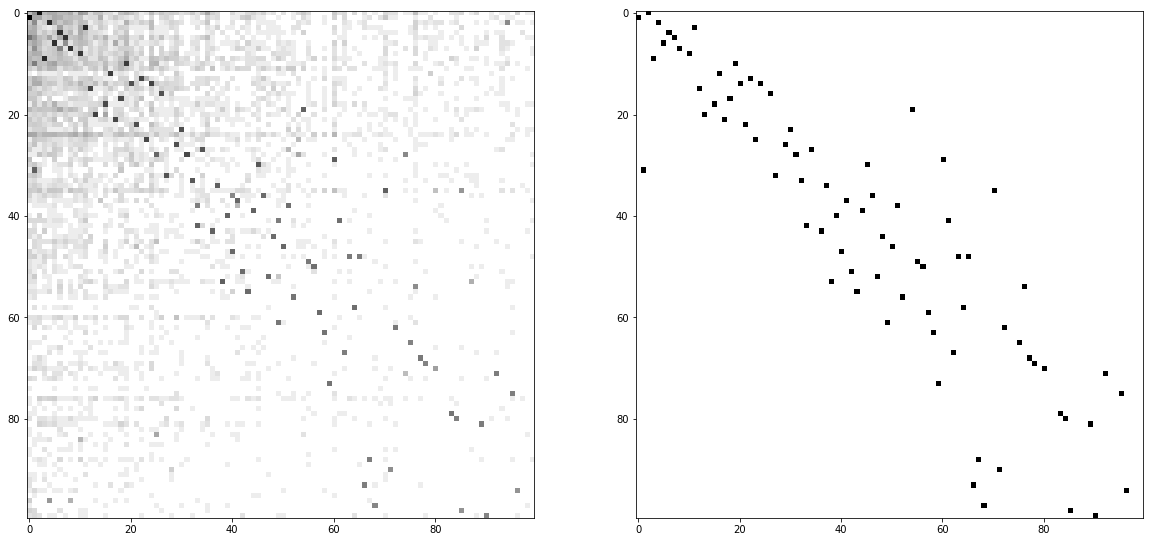

In [23]:
cut = 100
ca.plot_grs(gr[:cut, :cut], preds[:cut, :cut], s = 20, log = 1)

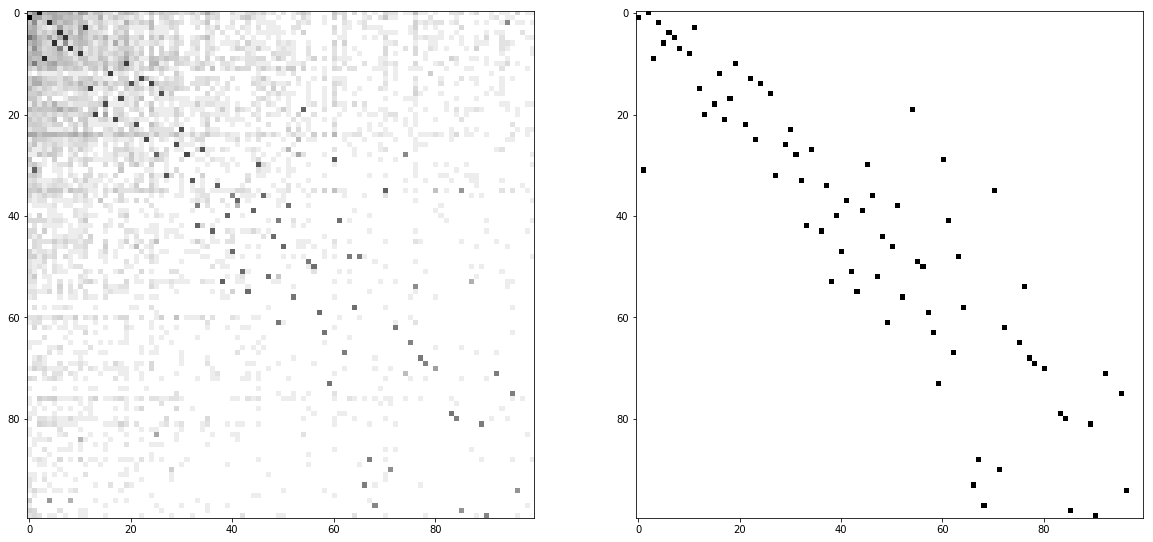

In [12]:
cut = 100
ca.plot_grs(gr[:cut, :cut], gr_restored[:cut, :cut], s = 20, log = 1)

In [10]:
def calc_noise_ratio(gr0, gr):
    return 1 - gr[gr0>0].sum() / gr.sum(), ((gr > 0).sum() - (gr0 > 0).sum()) / gr.flatten().shape[0]

In [6]:
arrs, weights = ca.restore_arrays_greedy(gr, threashold=2)

In [7]:
gr_restored = ca.graph_from_arrays(arrs, gr.shape[0])[0]

In [13]:
len([x for x in arrs if len(x) > 3])

46

In [43]:
calc_noise_ratio(gr_restored[:500, :500], gr[:500, :500])

(0.15619127416362444, 0.020043999999999999)

In [44]:
calc_noise_ratio(gr_restored[:100, :100], gr[:100,:100])

(0.13019157400241677, 0.27779999999999999)

# cut gr

In [24]:
ec =ca.EmbeddingsCalculator()
ec.make_argsorts(gr[:100,:100])

In [25]:
embs2 = ec.build_embeddings(gr[:100,:100])

Process ForkPoolWorker-32:
Process ForkPoolWorker-26:
Process ForkPoolWorker-30:
Process ForkPoolWorker-31:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-27:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Traceback (most recent call last):
Process ForkPoolWorker-25:
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.

In [26]:
preds2 = gb.predict(embs2).reshape(gr[:100,:100].shape)

In [30]:
embs2_sq = embs2.reshape(100,100, -1)

In [51]:
embs_sq = embs.reshape(gr.shape[0], gr.shape[1], -1)

In [52]:
gb.predict_proba(embs_sq[2, 5].reshape(1,-1))

array([[0.61947113, 0.38052887]])

In [66]:
gb.predict_proba(embs2_sq[2, 5].reshape(1,-1))

array([[0.99736337, 0.00263663]])

In [54]:
embs_sq[2, 5]

array([1.        , 1.        , 0.28552368, 0.29215017, 6.06145692,
       6.06145692])

In [55]:
gb.predict_proba([[1., 1., 0.28552368, 0.29215017, 6.06145692, 6.06145692]])

array([[0.61947113, 0.38052887]])

In [57]:
gr[2][:10]

array([ 53,  98,   7,  54,  30, 428,  28,  12,  17,  19])

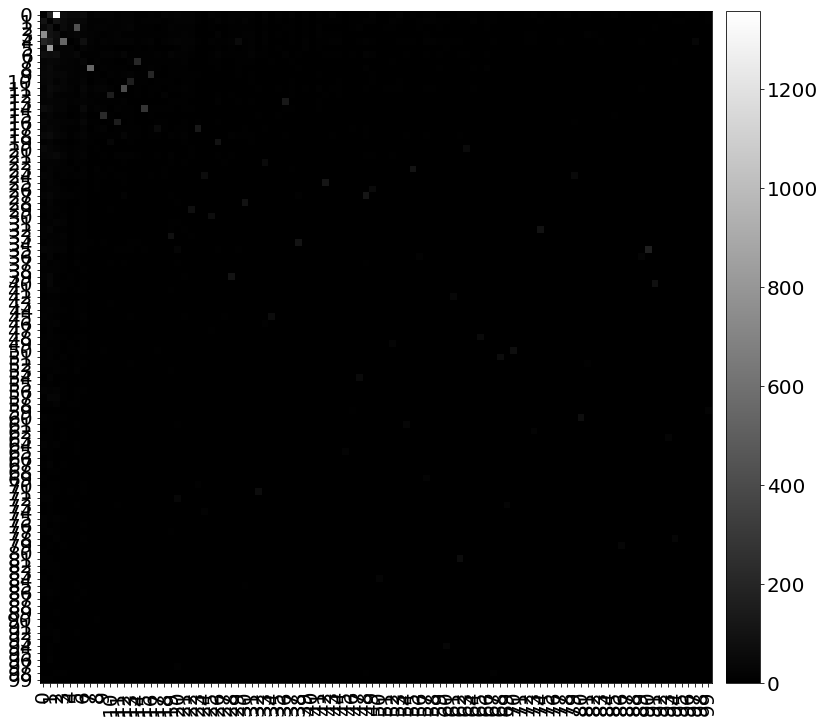

In [72]:
ca.plot_gr(gr[:100, :100], s = 20, all_ticks=1)

In [ ]:
2 5 1 

In [70]:
get_top_stats(gr, 2)

(array([428,  98,  54,  53,  30,  28,  24,  19,  18,  17]),
 array([ 5,  1,  3,  0,  4,  6, 13,  9, 12,  8]))

In [68]:
gr[1].sum()

1758

In [69]:
gr[:, 1].sum()

3733

In [ ]:
0

In [27]:
gr.shape

(2165, 2165)

In [6]:
cut = 100
ca.plot_grs(gr[:cut, :cut], preds2[:cut, :cut], s = 20, log = 1)

NameError: name 'preds2' is not defined

In [52]:
read =  ca.Read("../../data/SlO_10/SlO2_R1_pairs_10.txt")

In [55]:
read.correct_errors()

100%|██████████| 15890/15890 [00:44<00:00, 354.66it/s]


In [56]:
gr2 = read.graph_from_pairs()[0]

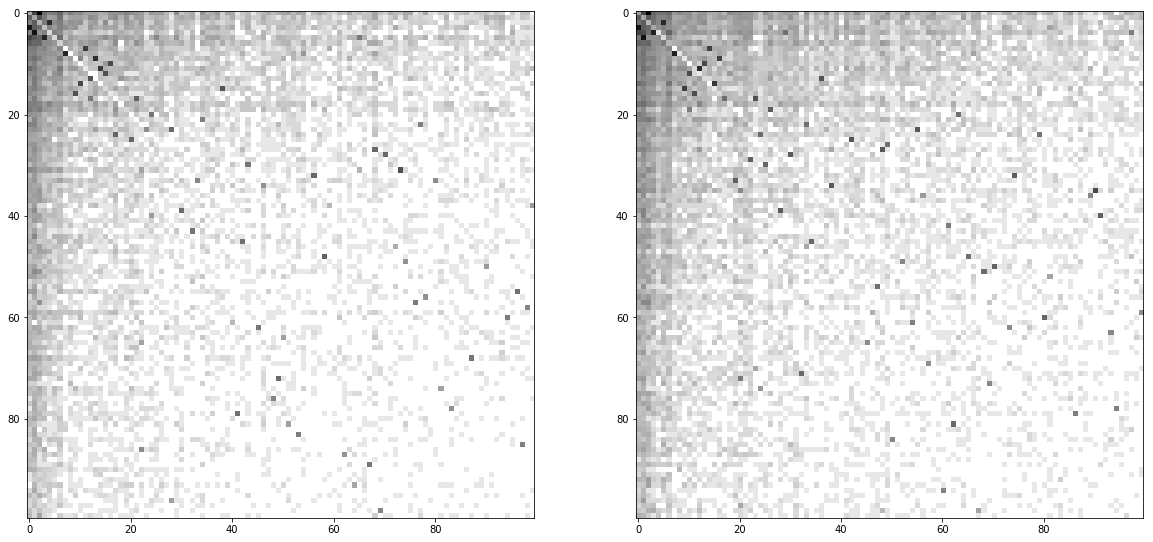

In [69]:
ca.plot_grs(gr2[:100, :100], gr[:100, :100], log = 1, s = 20)

In [81]:
def calc_noise_ratio(gr0, gr):
    return gr[gr0 > 0].sum() / (gr.sum() - gr[gr0 > 0].sum())

In [71]:
arrs, weights = ca.restore_arrays(gr)

In [72]:
restored_gr = ca.graph_from_arrays(arrs, gr.shape[0])[0]

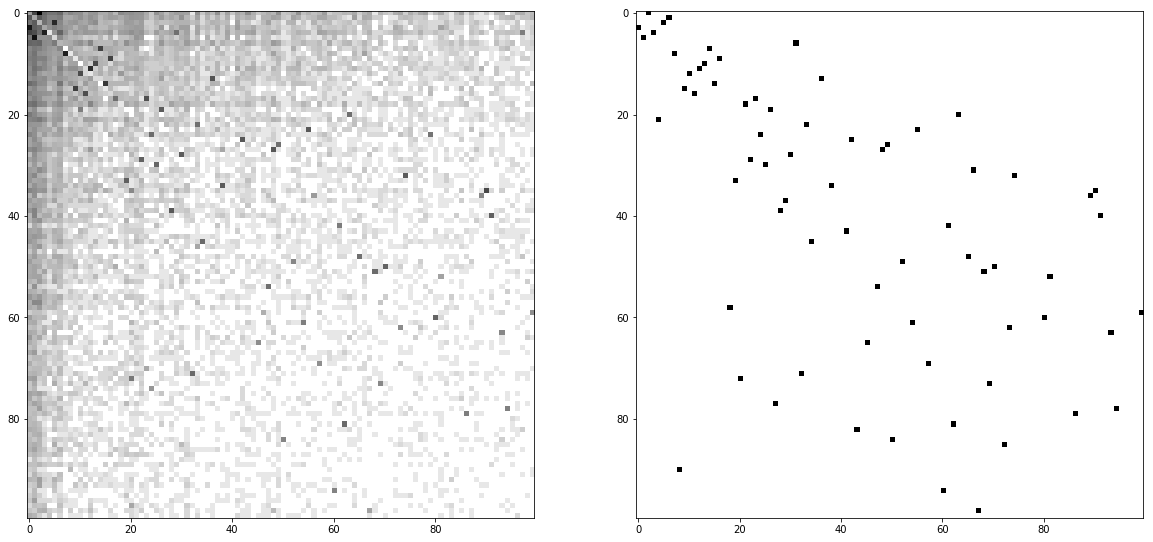

In [73]:
ca.plot_grs(gr[:100, :100], restored_gr[:100, :100], log = 1, s = 20)

In [79]:
gr[:10, :10]

array([[  15,  178, 1357,   73,   48,   48,   64,   18,   28,   22],
       [ 105,   11,  102,   57,   32,   32,   39,   11,   11,   15],
       [  53,   98,    7,   54,   30,  428,   28,   12,   17,   19],
       [ 748,   96,   69,   11,   23,   37,   25,   17,   14,    8],
       [ 200,  147,   60,  541,    1,   21,   80,   21,    9,   17],
       [  47,  840,   22,   22,   25,    2,   26,   11,    7,    8],
       [  77,   68,   77,   25,   23,   41,    7,    9,   10,   16],
       [  29,   42,   35,   24,   17,   14,   28,    0,   13,    7],
       [  33,   51,   23,   20,   16,   13,   14,  536,    1,   11],
       [  38,   46,   34,   35,   18,   11,   19,    8,   11,    1]])

In [82]:
calc_noise_ratio(restored_gr, gr)

0.29165781710914457

# PCA

In [52]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA(2)

In [55]:
pca.fit(embs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [57]:
embs_2 =pca.transform(embs)

In [61]:
embs_2_cut =embs_2.reshape(gr.shape[0], gr.shape[1], 2)[:100, :100].reshape(10000, 2)

In [66]:
mask = (preds > 0.3)[:100, :100].reshape(10000)

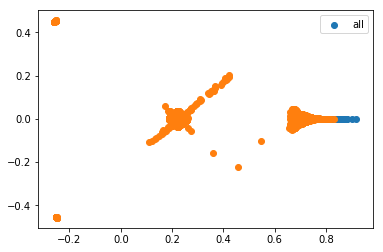

In [68]:
plt.scatter(embs_2_cut[mask, 0], embs_2_cut[mask, 1], label = 'all')
plt.scatter(embs_2_cut[np.logical_not(mask), 0], embs_2_cut[np.logical_not(mask), 1])
plt.legend()
plt.show()